# Обработка EDA 
(Exploratory Data Analysis, разведочный анализ данных) — это процесс анализа наборов данных для обобщения их основных характеристик, часто с использованием графических методов. 

## Цели и задачи
Понимание структуры и характеристик данных. Изучение размера набора, типов переменных, наличия пропущенных значений, дубликатов и других аспектов.
Выявление аномалий и выбросов. Значения, отклоняющиеся от общего паттерна, которые могут искажать выводы.
Идентификация связей и корреляций между переменными. Использование статистических мер для понимания, как одни факторы влияют на другие.
Подготовка данных для дальнейших этапов анализа. Очистка данных от шума, заполнение пропущенных значений, масштабирование или преобразование переменных.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 1. Загрузка данных
data = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx', sheet_name='Sheet1')
data.head

<bound method NDFrame.head of       Unnamed: 0    IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  \
0              0    6.239374  175.482382  28.125000           5.094096   
1              1    0.771831    5.402819   7.000000           3.961417   
2              2  223.808778  161.142320   0.720000           2.627117   
3              3    1.705624  107.855654  63.235294           5.097360   
4              4  107.131532  139.270991   1.300000           5.150510   
...          ...         ...         ...        ...                ...   
996          996   31.000104   34.999650   1.129017          12.934891   
997          997   31.999934   33.999415   1.062484          13.635345   
998          998   30.999883   33.999458   1.096761          13.991690   
999          999   31.998959   32.999644   1.031272          13.830180   
1000        1000   99.999531   99.999531   1.000000          13.380863   

      MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0

# Обработка

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Загрузка данных
def load_data(file_path):
    """
    Загружает данные из файла (CSV, Excel и т.д.)
    """
    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)
    elif file_path.endswith(('.xls', '.xlsx')):
        return pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format")

# Основная функция EDA
def perform_eda(df):
    """
    Выполняет разведочный анализ данных и обработку пропусков
    """
    # 1. Первичный осмотр данных
    print("=== Первичный осмотр данных ===")
    print(f"Размер данных: {df.shape}")
    print("\nПервые 5 строк:")
    print(df.head())
    print("\nИнформация о данных:")
    print(df.info())
    print("\nОписательная статистика:")
    print(df.describe(include='all'))
    
    # 2. Анализ пропущенных значений
    print("\n=== Анализ пропущенных значений ===")
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_data = pd.DataFrame({
        'Количество пропусков': missing_values,
        'Процент пропусков': missing_percent.round(2)
    })
    print(missing_data[missing_data['Количество пропусков'] > 0])
    
    # Визуализация пропусков
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Визуализация пропущенных значений")
    plt.show()
    
    # 3. Обработка пропущенных значений
    print("\n=== Обработка пропущенных значений ===")
    df_cleaned = handle_missing_values(df)
    
    # 4. Анализ после обработки
    print("\n=== Результаты после обработки пропусков ===")
    print(f"Осталось пропусков: {df_cleaned.isnull().sum().sum()}")
    
    # 5. Анализ распределений и выбросов
    print("\n=== Анализ распределений ===")
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        df_cleaned[numeric_cols].hist(bins=20, figsize=(15, 10))
        plt.suptitle("Распределения числовых переменных")
        plt.show()
        
        # Boxplot для выявления выбросов
        plt.figure(figsize=(15, 5))
        df_cleaned[numeric_cols].boxplot()
        plt.title("Boxplot для числовых переменных")
        plt.xticks(rotation=45)
        plt.show()
    
    # 6. Анализ категориальных переменных
    cat_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        print("\n=== Анализ категориальных переменных ===")
        for col in cat_cols:
            print(f"\nЧастота значений для {col}:")
            print(df_cleaned[col].value_counts(normalize=True).head(10))
            
            # Визуализация топ-10 категорий
            plt.figure(figsize=(10, 4))
            df_cleaned[col].value_counts().head(10).plot(kind='bar')
            plt.title(f"Топ-10 категорий для {col}")
            plt.show()
    
    return df_cleaned




In [5]:

""" Обрабатывает пропущенные значения в данных
    Параметры:
    - df: DataFrame с данными
    - threshold: процент пропусков, после которого столбец удаляется (по умолчанию 30%)
    - strategy: стратегия обработки ('auto', 'drop', 'fill')
    Возвращает:
    - DataFrame с обработанными пропусками
    """
def handle_missing_values(df, threshold=30, strategy='auto'):
    
    df_cleaned = df.copy()
    
    # 1. Удаление столбцов с высоким процентом пропусков
    missing_percent = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100
    cols_to_drop = missing_percent[missing_percent > threshold].index
    df_cleaned = df_cleaned.drop(columns=cols_to_drop)
    print(f"Удалены столбцы с >{threshold}% пропусков: {list(cols_to_drop)}")
    
    # 2. Обработка оставшихся пропусков
    for col in df_cleaned.columns:
        if df_cleaned[col].isnull().any():
            # Для числовых переменных
            if pd.api.types.is_numeric_dtype(df_cleaned[col]):
                if strategy == 'auto' or strategy == 'fill':
                    # Замена медианой (менее чувствительна к выбросам)
                    median_val = df_cleaned[col].median()
                    df_cleaned[col] = df_cleaned[col].fillna(median_val)
                    print(f"Заполнены пропуски в {col} медианой: {median_val:.2f}")
            # Для категориальных переменных
            else:
                if strategy == 'auto' or strategy == 'fill':
                    # Замена модой (наиболее частым значением)
                    mode_val = df_cleaned[col].mode()[0]
                    df_cleaned[col] = df_cleaned[col].fillna(mode_val)
                    print(f"Заполнены пропуски в {col} модой: {mode_val}")
    
    # 3. Удаление строк, если остались пропуски (опционально)
    if df_cleaned.isnull().any().any() and (strategy == 'drop' or strategy == 'auto'):
        initial_rows = len(df_cleaned)
        df_cleaned = df_cleaned.dropna()
        final_rows = len(df_cleaned)
        print(f"Удалены строки с пропусками. Удалено строк: {initial_rows - final_rows}")
    
    return df_cleaned



=== Первичный осмотр данных ===
Размер данных: (1001, 214)

Первые 5 строк:
   Unnamed: 0    IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  \
0           0    6.239374  175.482382  28.125000           5.094096   
1           1    0.771831    5.402819   7.000000           3.961417   
2           2  223.808778  161.142320   0.720000           2.627117   
3           3    1.705624  107.855654  63.235294           5.097360   
4           4  107.131532  139.270991   1.300000           5.150510   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0        5.094096           0.387225        0.387225  0.417362  42.928571   
1        3.961417           0.533868        0.533868  0.462473  45.214286   
2        2.627117           0.543231        0.543231  0.260923  42.187500   
3        5.097360           0.390603        0.390603  0.377846  41.862069   
4        5.150510           0.270476        0.270476  0.429038  36.514286   

   ...  fr_sulfide  fr_sulfonamd  

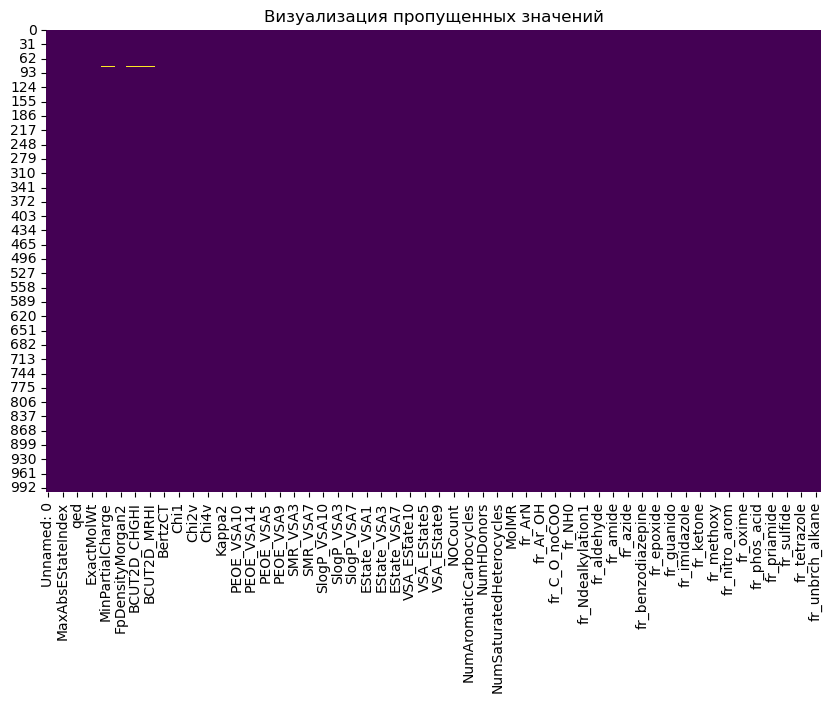


=== Обработка пропущенных значений ===
Удалены столбцы с >30% пропусков: []
Заполнены пропуски в MaxPartialCharge медианой: 0.25
Заполнены пропуски в MinPartialCharge медианой: -0.39
Заполнены пропуски в MaxAbsPartialCharge медианой: 0.43
Заполнены пропуски в MinAbsPartialCharge медианой: 0.25
Заполнены пропуски в BCUT2D_MWHI медианой: 16.56
Заполнены пропуски в BCUT2D_MWLOW медианой: 9.72
Заполнены пропуски в BCUT2D_CHGHI медианой: 2.51
Заполнены пропуски в BCUT2D_CHGLO медианой: -2.36
Заполнены пропуски в BCUT2D_LOGPHI медианой: 2.49
Заполнены пропуски в BCUT2D_LOGPLOW медианой: -2.40
Заполнены пропуски в BCUT2D_MRHI медианой: 5.94
Заполнены пропуски в BCUT2D_MRLOW медианой: -0.11

=== Результаты после обработки пропусков ===
Осталось пропусков: 0

=== Анализ распределений ===


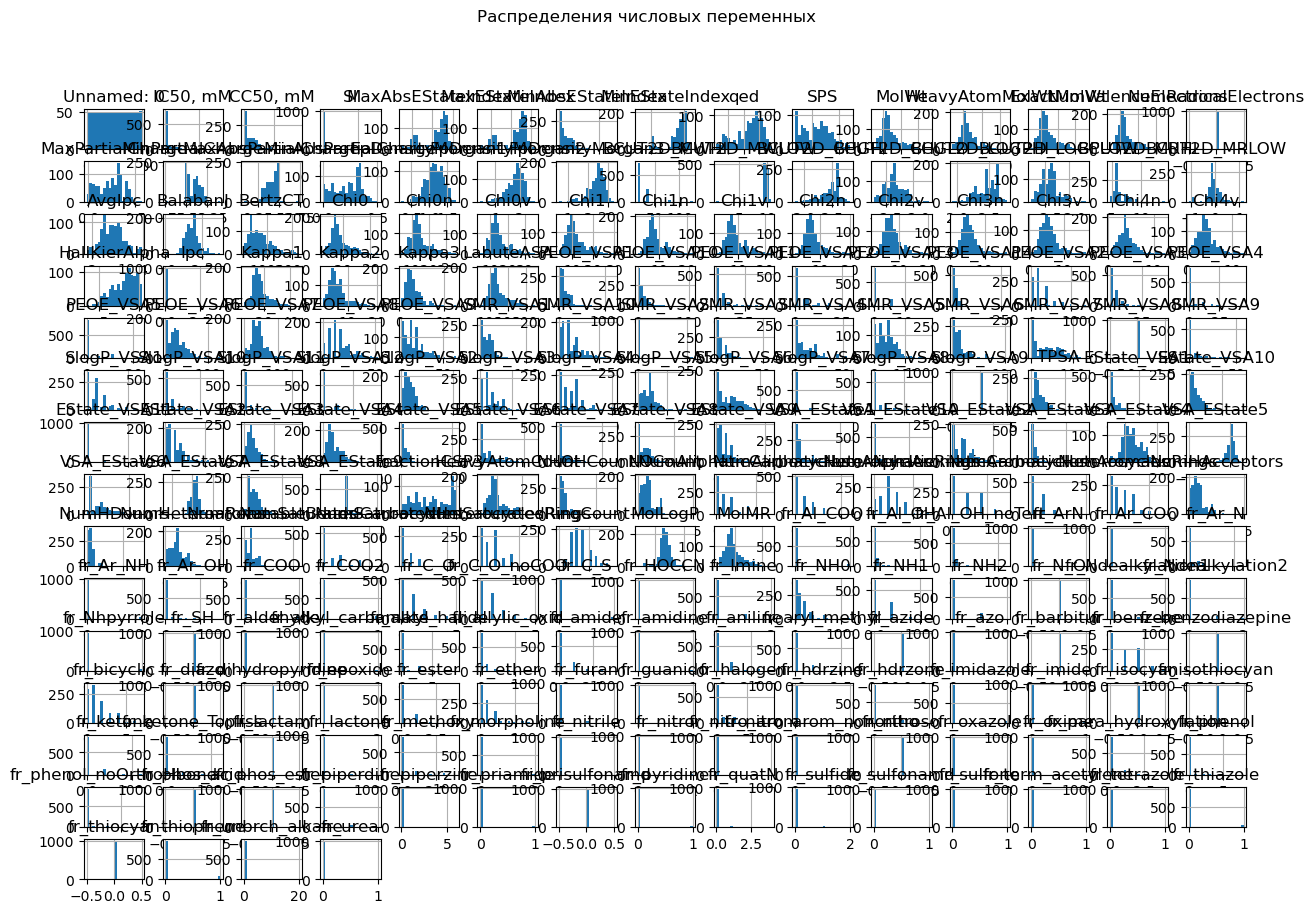

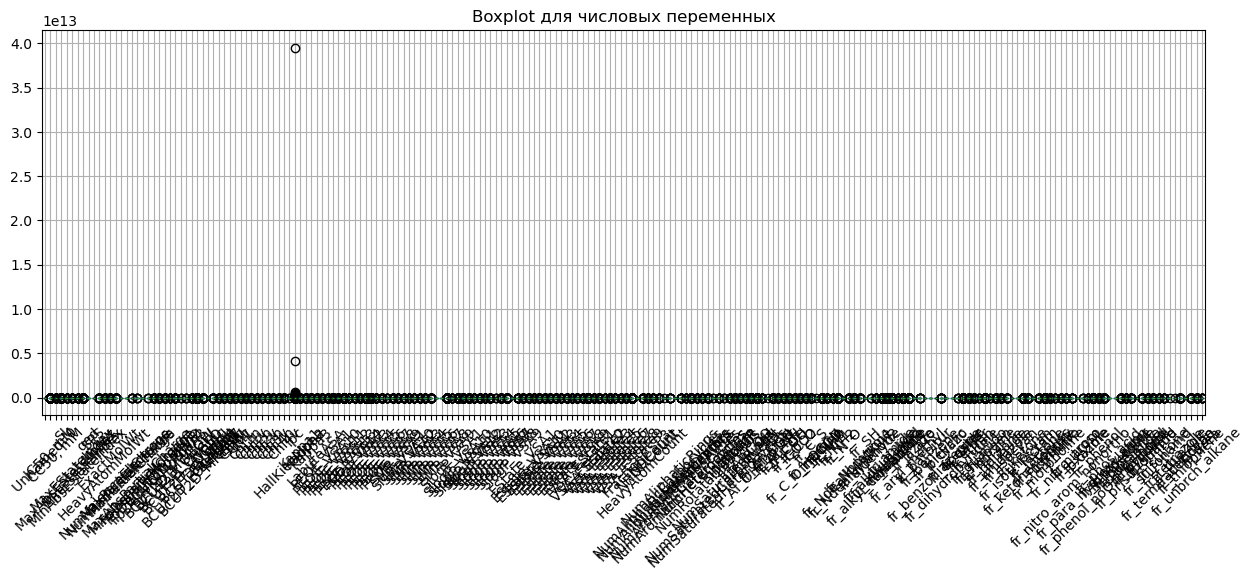


Обработанные данные сохранены в 'cleaned_data.csv'


In [11]:
if __name__ == "__main__":
    # Замените 'your_data.csv' на путь к вашему файлу с данными
    file_path = 'Данные_для_курсовои_Классическое_МО.xlsx'
    
    try:
        # Загрузка данных
        data = load_data(file_path)
        
        # Выполнение EDA и обработка пропусков
        cleaned_data = perform_eda(data)
        
        # Сохранение обработанных данных (опционально)
        cleaned_data.to_csv('cleaned_data.csv', index=False)
        print("\nОбработанные данные сохранены в 'cleaned_data.csv'")
        
    except Exception as e:
        print(f"Произошла ошибка: {str(e)}")

Основные статистики:
         Unnamed: 0     IC50, mM     CC50, mM            SI  MaxAbsEStateIndex  \
count  1001.000000  1001.000000  1001.000000   1001.000000        1001.000000   
mean    500.000000   222.805156   589.110728     72.508823          10.831637   
std     289.108111   402.169734   642.867508    684.482739           3.307505   
min       0.000000     0.003517     0.700808      0.011489           2.321942   
25%     250.000000    12.515396    99.999036      1.433333           9.252350   
50%     500.000000    46.585183   411.039342      3.846154          12.179236   
75%     750.000000   224.975928   894.089176     16.566667          13.167843   
max    1000.000000  4128.529377  4538.976189  15620.600000          15.933463   

       MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex          qed  \
count     1001.000000        1001.000000     1001.000000  1001.000000   
mean        10.831637           0.180681       -0.967237     0.580412   
std          3.307505        

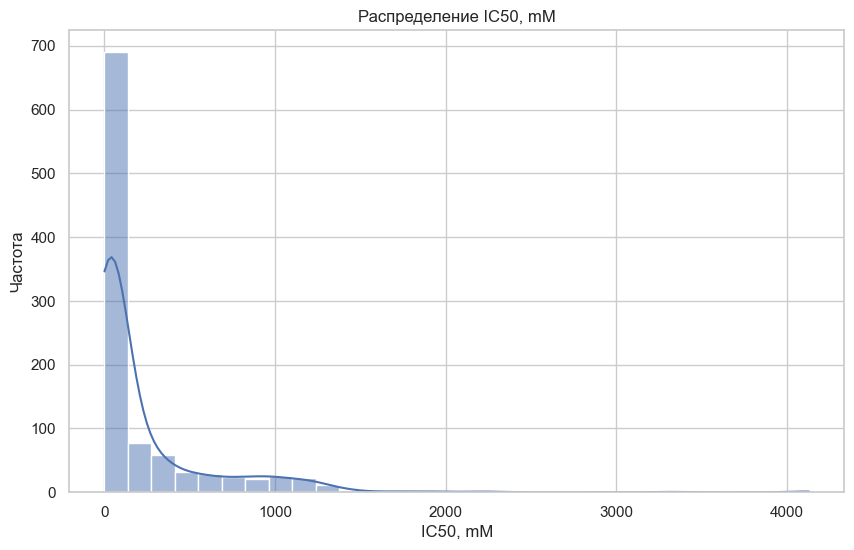

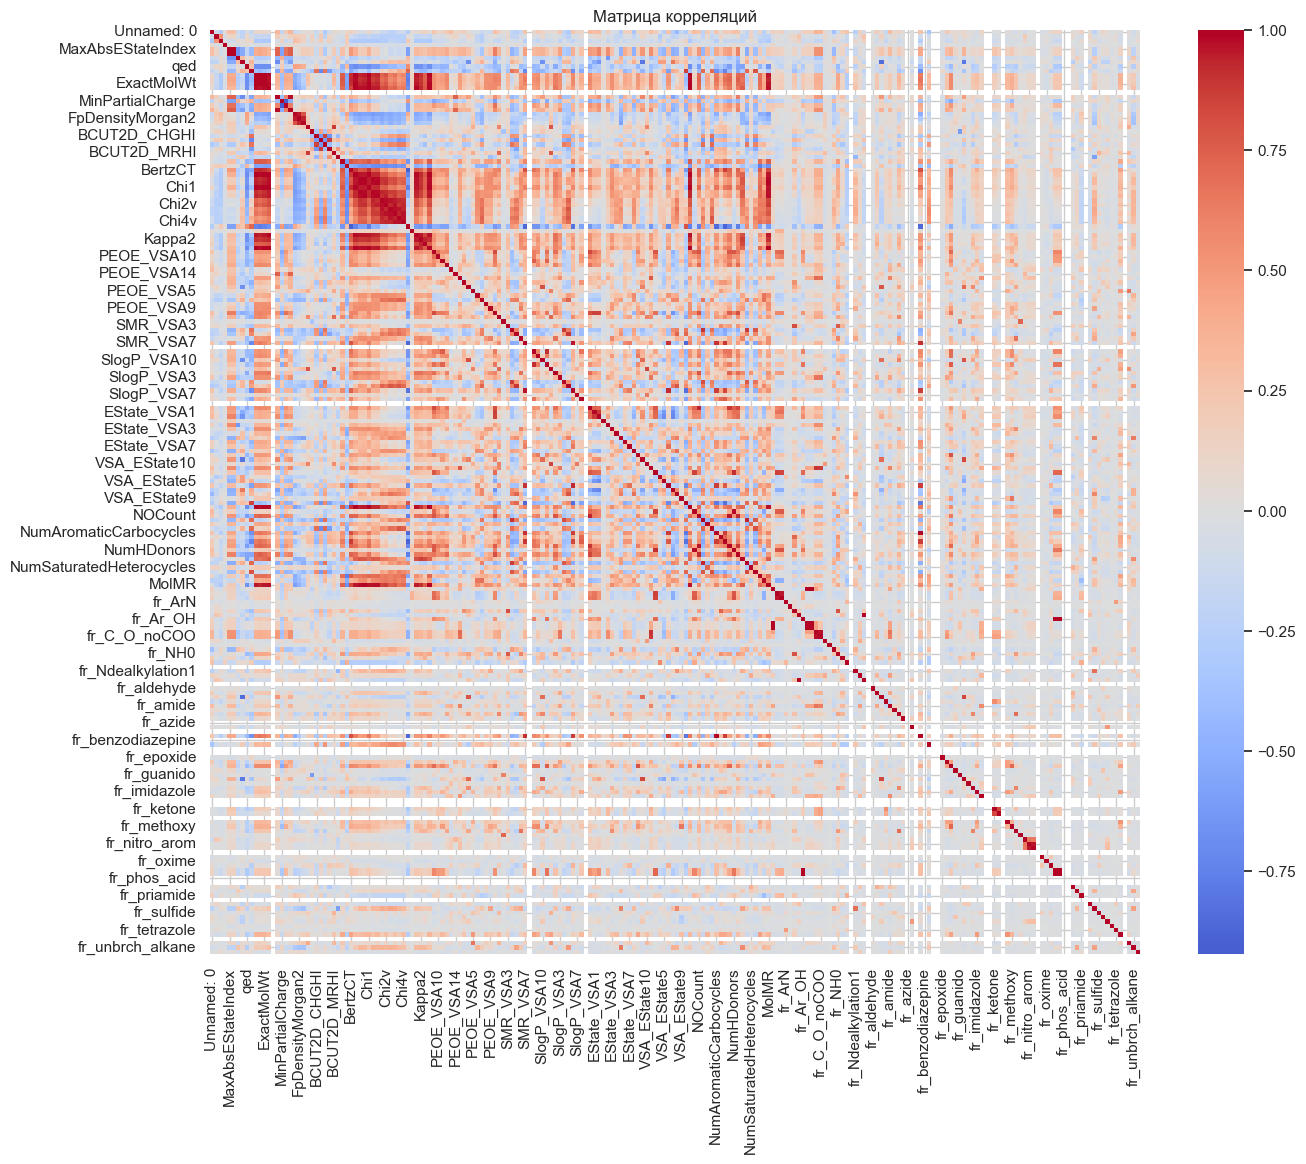

In [21]:
# Выбор целевой переменной и признаков
# В данных есть IC50 (концентрация ингибирования) и CC50 (токсичность), SI (индекс селективности)
target = 'IC50, mM'  # Можно выбрать другую целевую переменную
features = data.columns.drop(['IC50, mM', 'CC50, mM', 'SI'])  # Исключаем целевые и производные переменные

# 3. Разведочный анализ данных (EDA)
# Основные статистики
print("Основные статистики:\n", data.describe())

# Распределение целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(data[target], bins=30, kde=True)
plt.title(f'Распределение {target}')
plt.xlabel(target)
plt.ylabel('Частота')
plt.show()

# Корреляционный анализ
corr_matrix = data.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()


# Ключевые выводы и закономерности:

IC50 и CC50 имеют сильную правостороннюю асимметрию (большинство значений сосредоточено внизу, но есть длинный хвост больших значений)

Рекомендуется логарифмическое преобразование для моделей регрессии

SI (индекс селективности) также имеет асимметричное распределение

## Корреляционный анализ:

Наибольшие корреляции с IC50: MaxEStateIndex, SPS, qed

CC50 сильнее коррелирует с молекулярными дескрипторами, чем IC50

SI имеет слабые корреляции с большинством признаков, что делает его прогнозирование более сложным

## Рекомендации для моделей:

### Для регрессии:

Логарифмическое преобразование целевых переменных

Регуляризация (Lasso/Ridge) для борьбы с мультиколлинеарностью

Для SI: рассмотреть более сложные модели (ансамбли, нейронные сети)

### Для классификации:

Классы сбалансированы для медианных разделений (~50/50)

Для SI > 8 распределение 70/30 - может потребоваться балансировка

Рекомендуются деревья (Random Forest, XGBoost) как устойчивые к выбросам

## Дополнительные рекомендации:

Создание новых признаков на основе EStateIndex для классификации SI > 8

Кластеризация данных и построение отдельных моделей для кластеров